# Scheduling: Is it worth it?

In the most generic form - what does one gain from scheduling?

Since all scheduling problems are some form of TSP problem, a fair comparison is the difference between randomly visiting all cities, compared to visiting them in the most efficient manner.

Let's do a simulation!

In [1]:
import random
random.seed(42)
from graph import Graph
from graph.random import random_xy_graph
import itertools


First I'll create a random x,y graph

In [2]:
g = random_xy_graph(nodes=20, x_max=800, y_max=400)  # a fully connected graph.
print(g.nodes())

[(655, 58), (26, 380), (282, 126), (229, 72), (755, 53), (693, 380), (559, 45), (605, 217), (33, 16), (96, 112), (239, 259), (617, 14), (575, 102), (734, 333), (719, 280), (430, 113), (460, 302), (285, 4), (778, 82), (715, 217)]


Then I'll simplify it to use simple node id's whilst keeping the pytagoran distance.

In [3]:
def simplify(graph):
    """ helper that simplifies the xy to mere node ids."""
    d = {}
    cnt = itertools.count(1)
    c2 = []
    for s, e, dst in graph.edges():
        if s not in d:
            d[s] = next(cnt)
        if e not in d:
            d[e] = next(cnt)
        c2.append((d[s], d[e], dst))

    g = Graph(from_list=c2)
    return g


g = simplify(g)

As the third step I'll compute a circuit in the graph based on:

1. Randomly connect from one node to another.
2. Connect to the nearest neighbour.

In [4]:
def circuit(g, nn=False):
    assert isinstance(g, Graph)
    start = random.choice(g.nodes())
    path = [start]
    q = [start]
    while q:
        n = q.pop(0)
        n2s = [(d,s,e) for s,e,d in g.edges(from_node=n) if e not in path]
        if not n2s:
            return path

        if nn:
            n2s.sort()  # nearest on top.

        d,s,e = n2s[0]
        q.append(e)
        path.append(e)

Now I can run my most basic comparison:

In [5]:
random_circuit = circuit(g)
print("Length of random circuit:", g.distance_from_path(random_circuit))

Length of random circuit: 5791.51737465096


In [6]:

nn_circuit = circuit(g, nn=True)
print("Length of nearest neighbour circuit:", g.distance_from_path(nn_circuit))

Length of nearest neighbour circuit: 2471.6650590127306


In [7]:
optimal_distance, optimal_circuit = g.solve_tsp()
print("Length of TSP circuit:", optimal_distance)

Length of TSP circuit: 2718.145963654061


To emphasize:

| circuit | length | N | % |
|---|---|---|---|
| Random circuit | 7060 | 2.597 | 100.00% |
| NN circuit | 3073 | 1.131 | 43.53% |
| Optimal circuit | 2718 | 1.000 | 38.49% |

Let's check how this adds up at scale:

In [8]:
results = {'nc': [], 'r': [], 'nn': [], 'o': [] }
for node_count in range(5,400,10):
    results['nc'].append(node_count)

    g = random_xy_graph(nodes=node_count, x_max=800, y_max=400)  # a fully connected graph.
    g = simplify(g)
    random_circuit = circuit(g)
    
    results['r'].append(g.distance_from_path(random_circuit))
    
    nn_circuit = circuit(g, nn=True)
    results['nn'].append(g.distance_from_path(nn_circuit))

    optimal_distance, optimal_circuit = g.solve_tsp()
    results['o'].append(optimal_distance)


And let's add a little pretty chart:

In [9]:
import matplotlib.pyplot as plt
import numpy as np

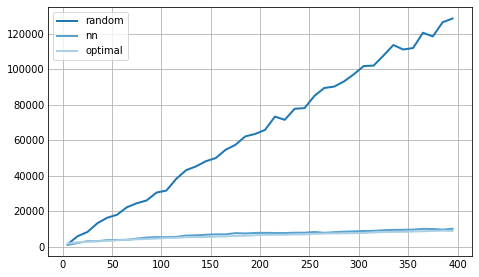

In [10]:

plt.style.use('_mpl-gallery')

# plot
fig, ax = plt.subplots()

ax.plot(results['nc'], results['r'], linewidth=2.0, label='random')
ax.plot(results['nc'], results['nn'], linewidth=2.0, label='nn')
ax.plot(results['nc'], results['o'], linewidth=2.0, label='optimal')
ax.legend()

plt.show()

In [11]:
print("The ratio between NN and Optimal retains a", sum(results['nn']) / sum(results['o']), "gap")

The ratio between NN and Optimal retains a 1.1313931828343775 gap


**Conclusion: 

| circuit | length | N | % |
|---|---|---|---|
| Random circuit | n/a | n/a | n/a |
| NN circuit | n/a | 1.131 | 100% |
| Optimal circuit | n/a | 1.000 | 88.39% |